In [1]:
MAX_TIME = 720
INIT_SIZE = 20
DEVICE = "cpu" # "cuda:0"

In [2]:
import pickle
import socket
from datetime import datetime
from dateutil.tz import tzlocal
start_time = datetime.now(tzlocal())
HOSTNAME = socket.gethostname().split(".")[0]
experiment_name = '14-torch' + "_" + HOSTNAME + "_" + str(MAX_TIME) + "min_" + str(INIT_SIZE) + "init_" + str(start_time).split(".", 1)[0].replace(' ', '_')
experiment_name = experiment_name.replace(':', '-')
experiment_name

'14-torch_maans05_720min_20init_2023-05-12_23-23-51'

# Chapter 14: Sequential Parameter Optimization Compared to Ray Tune
## Hyperparameter Tuning: pytorch wth cifar10 Data

* This notebook exemplifies hyperparameter tuning with SPOT (spotPython).
* The hyperparameter software SPOT was developed in R (statistical programming language), see Open Access book "Hyperparameter Tuning for Machine and Deep Learning with R - A Practical Guide", available here: [https://link.springer.com/book/10.1007/978-981-19-5170-1](https://link.springer.com/book/10.1007/978-981-19-5170-1).


In [3]:
pip list | grep  "spot[RiverPython]"

spotPython               0.0.69
spotRiver                0.0.91
Note: you may need to restart the kernel to use updated packages.


In [4]:
# import sys
# !{sys.executable} -m pip install --upgrade build
# !{sys.executable} -m pip install --upgrade --force-reinstall spotPython


In [5]:
from tabulate import tabulate
import copy
import warnings
import numbers
import json
import calendar
import math
import datetime as dt
import numpy as np
from math import inf
import pandas as pd

from scipy.optimize import differential_evolution

import matplotlib.pyplot as plt

from functools import partial

import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
from torchvision import datasets
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor

from spotPython.spot import spot
from spotPython.hyperparameters.values import (
    add_core_model_to_fun_control,
    assign_values,
    convert_keys,
    get_bound_values,
    get_default_hyperparameters_for_core_model,
    get_default_values,
    get_dict_with_levels_and_types,
    get_values_from_dict,
    get_var_name,
    get_var_type,
    iterate_dict_values,
    modify_hyper_parameter_levels,
    modify_hyper_parameter_bounds,
    replace_levels_with_positions,
    return_conf_list_from_var_dict,
    get_one_core_model_from_X,
    transform_hyper_parameter_values,
    get_dict_with_levels_and_types,
    convert_keys,
    iterate_dict_values,
)

from spotPython.torch.traintest import evaluate_cv, evaluate_hold_out
from spotPython.utils.convert import class_for_name
from spotPython.utils.eda import (
    get_stars,
    gen_design_table)
from spotPython.utils.transform import transform_hyper_parameter_values
from spotPython.utils.convert import get_Xy_from_df
from spotPython.utils.init import fun_control_init
from spotPython.plot.validation import plot_cv_predictions, plot_roc, plot_confusion_matrix

from spotPython.data.torch_hyper_dict import TorchHyperDict
from spotPython.fun.hypertorch import HyperTorch

warnings.filterwarnings("ignore")

from spotPython.torch.netcifar10 import Net_CIFAR10

In [6]:
print(torch.__version__)
# Check that MPS is available
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    mps_device = torch.device("mps")
    print("MPS device: ", mps_device)

2.0.0
MPS device:  mps


## 0. Initialization of the Empty `fun_control` Dictionary

In [7]:
fun_control = fun_control_init()

## 1. Load Cifar10 Data 

The data loading is implemented as in the Section "Data loaders" in the PyTorch tutorial [Hyperparameter Tuning  with Ray Tune](https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html).

In [8]:
def load_data(data_dir="./data"):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    trainset = torchvision.datasets.CIFAR10(
        root=data_dir, train=True, download=True, transform=transform)

    testset = torchvision.datasets.CIFAR10(
        root=data_dir, train=False, download=True, transform=transform)

    return trainset, testset

In [9]:
train, test = load_data()
train.data.shape, test.data.shape

Files already downloaded and verified
Files already downloaded and verified


((50000, 32, 32, 3), (10000, 32, 32, 3))

In [10]:
n_samples = len(train)
# add the dataset to the fun_control
fun_control.update({"data": None, # dataset,
               "train": train,
               "test": test,
               "n_samples": n_samples,
               "target_column": None})

## 2. Specification of the Preprocessing Model

Because the Ray Tune hyperparameter tuning does not use a preprocessing model, the preprocessing model is set to `None` here.

In [11]:
# categorical_columns = []
# one_hot_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
# prep_model = ColumnTransformer(
#         transformers=[
#             ("categorical", one_hot_encoder, categorical_columns),
#         ],
#         remainder=StandardScaler(),
#     )
prep_model = None
fun_control.update({"prep_model": prep_model})

## 3. Select `algorithm` and `core_model_hyper_dict`

The same model as implemented as in the Section "Configurable neural network" in the PyTorch tutorial [Hyperparameter Tuning  with Ray Tune](https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html) is used here. `spotPython` implements a class which is similar to the class described in the PyTorch tutorial. The class is called `Net_CIFAR10`   and is implemented in the file `netcifar10.py`. The class is imported here.

Note: In addition to the class Net from the PyTorch tutorial, the class Net_CIFAR10 has additional attributes, namely:

* learning rate (`lr`),
* batchsize (`batch_size`),
* epochs (`epochs`), and
* k_folds (`k_folds`).

Further attributes can be easily added to the class, e.g., `optimizer` or `loss_function`.

In [12]:
core_model = Net_CIFAR10
fun_control = add_core_model_to_fun_control(core_model=core_model,
                              fun_control=fun_control,
                              hyper_dict=TorchHyperDict,
                              filename=None)

### The `hyper_dict` Hyperparameters for the Selected Algorithm

`spotPython` uses simple `JSON` files for the specification of the hyperparameters. The `JSON` file for the `core_model` is called `torch_hyper_dict.json`. The corresponding entries for the `Net_CIFAR10` class are shown below.

```json
{"Net_CIFAR10":
    {
        "l1": {
            "type": "int",
            "default": 5,
            "transform": "transform_power_2_int",
            "lower": 2,
            "upper": 9},
        "l2": {
            "type": "int",
            "default": 5,
            "transform": "transform_power_2_int",
            "lower": 2,
            "upper": 9},
        "lr": {
            "type": "float",
            "default": 1e-03,
            "transform": "None",
            "lower": 1e-05,
            "upper": 1e-02},
        "batch_size": {
            "type": "int",
            "default": 4,
            "transform": "transform_power_2_int",
            "lower": 1,
            "upper": 4},
        "epochs": {
                "type": "int",
                "default": 3,
                "transform": "transform_power_2_int",
                "lower": 1,
                "upper": 4},
        "k_folds": {
            "type": "int",
            "default": 2,
            "transform": "None",
            "lower": 2,
            "upper": 3},
        "patience": {
            "type": "int",
            "default": 5,
            "transform": "None",
            "lower": 2,
            "upper": 10},
    }
}
```

Each entry in the `JSON` file represents one hyperparameter with the following structure:
`type`, `default`, `transform`, `lower`, and `upper`.


### Categorical Hyperparameters

In contrast to Ray Tune, `spotPython` can handle numerical, boolean, and categorical hyperparameters. Since `Ray Tune` does not tune categorical hyperparameters, they are not used here. However, they can be specified in the `JSON` file in a similar way as the numerical hyperparameters as shown below:

```json
"factor_hyperparameter": {
    "levels": ["A", "B", "C"],
    "type": "factor",
    "default": "B",
    "transform": "None",
    "core_model_parameter_type": "str",
    "lower": 0,
    "upper": 2},
```

## 4. Modify `hyper_dict` Hyperparameters for the Selected Algorithm aka `core_model`

After specifying the model, the corresponding hyperparameters, their types and bounds are loaded from the `JSON` file `torch_hyper_dict.json`. After loading, the user can modify the hyperparameters, e.g., the bounds.
`spotPython` provides a clever rule for de-activating hyperparameters. If the lower and the upper bound are set to identical values, the hyperparameter is de-activated. This is useful for the hyperparameter tuning, because it allows to specify a hyperparameter in the `JSON` file, but to de-activate it in the `fun_control` dictionary. This is done in the next step.

### Modify hyperparameter of type numeric and integer (boolean)

Since the hyperparameter `k_folds` is not used in the PyTorch tutorial, it is de-activated here by setting the lower and upper bound to the same value.

In [13]:
fun_control = modify_hyper_parameter_bounds(fun_control, "k_folds", bounds=[0, 0])
fun_control = modify_hyper_parameter_bounds(fun_control, "patience", bounds=[2, 2])
fun_control["core_model_hyper_dict"]

{'l1': {'type': 'int',
  'default': 5,
  'transform': 'transform_power_2_int',
  'lower': 2,
  'upper': 9},
 'l2': {'type': 'int',
  'default': 5,
  'transform': 'transform_power_2_int',
  'lower': 2,
  'upper': 9},
 'lr': {'type': 'float',
  'default': 0.001,
  'transform': 'None',
  'lower': 1e-05,
  'upper': 0.01},
 'batch_size': {'type': 'int',
  'default': 4,
  'transform': 'transform_power_2_int',
  'lower': 1,
  'upper': 4},
 'epochs': {'type': 'int',
  'default': 3,
  'transform': 'transform_power_2_int',
  'lower': 3,
  'upper': 4},
 'k_folds': {'type': 'int',
  'default': 2,
  'transform': 'None',
  'lower': 0,
  'upper': 0},
 'patience': {'type': 'int',
  'default': 5,
  'transform': 'None',
  'lower': 2,
  'upper': 2}}

### Modify hyperparameter of type factor

In a similar manner as for the numerical hyperparameters, the categorical hyperparameters can be modified. For example, the hyperparameter `leaf_model` is de-activated here by choosing only one value `"LinearRegression"`.

In [14]:
# fun_control = modify_hyper_parameter_levels(fun_control, "leaf_model", ["LinearRegression"])

## 5. Selection of the Objective (Loss) Function

There are two metrics:

    1. `metric` is used for the river based evaluation via `eval_oml_iter_progressive`.
    2. `metric_sklearn` is used for the sklearn based evaluation.

**Important**:

* `spotPython` performs minimization by default.
* If accuracy should be maximized, then the objective function has to be multiplied by -1. Therefore, `weights` is set to -1 in this case.

In [15]:
fun = HyperTorch(seed=123, log_level=50).fun_torch
weights = 1.0
shuffle = True
eval = "train_hold_out"
device = DEVICE
show_batch_interval = 100_000

fun_control.update({
               "data_dir": None,
               "checkpoint_dir": None,
               "horizon": None,
               "oml_grace_period": None,
               "weights": weights,
               "step": None,
               "log_level": 50,
               "weight_coeff": None,
               "metric": None,
               "metric_sklearn": None,
               "shuffle": shuffle,
               "eval": eval,
               "device": device,
               "show_batch_interval": show_batch_interval,
               })

## 6. Calling the SPOT Function

### Prepare the SPOT Parameters

* Get types and variable names as well as lower and upper bounds for the hyperparameters.

In [16]:
var_type = get_var_type(fun_control)
var_name = get_var_name(fun_control)
fun_control.update({"var_type": var_type,
                    "var_name": var_name})

lower = get_bound_values(fun_control, "lower")
upper = get_bound_values(fun_control, "upper")

In [17]:
print(gen_design_table(fun_control))

| name       | type   |   default |   lower |   upper | transform             |
|------------|--------|-----------|---------|---------|-----------------------|
| l1         | int    |     5     |   2     |    9    | transform_power_2_int |
| l2         | int    |     5     |   2     |    9    | transform_power_2_int |
| lr         | float  |     0.001 |   1e-05 |    0.01 | None                  |
| batch_size | int    |     4     |   1     |    4    | transform_power_2_int |
| epochs     | int    |     3     |   3     |    4    | transform_power_2_int |
| k_folds    | int    |     2     |   0     |    0    | None                  |
| patience   | int    |     5     |   2     |    2    | None                  |


### Run the `Spot` Optimizer

* Run SPOT for approx. x mins (`max_time`).
* Note: the run takes longer, because the evaluation time of initial design (here: `initi_size`, 20 points) is not considered.

In [18]:
from spotPython.hyperparameters.values import get_default_hyperparameters_as_array
hyper_dict=TorchHyperDict().load()
X_start = get_default_hyperparameters_as_array(fun_control, hyper_dict)
X_start

array([[5.e+00, 5.e+00, 1.e-03, 4.e+00, 3.e+00, 2.e+00, 5.e+00]])

In [19]:
spot_tuner = spot.Spot(fun=fun,
                   lower = lower,
                   upper = upper,
                   fun_evals = inf,
                   fun_repeats = 1,
                   max_time = MAX_TIME,
                   noise = False,
                   tolerance_x = np.sqrt(np.spacing(1)),
                   var_type = var_type,
                   var_name = var_name,
                   infill_criterion = "y",
                   n_points = 1,
                   seed=123,
                   log_level = 50,
                   show_models= False,
                   show_progress= True,
                   fun_control = fun_control,
                   design_control={"init_size": INIT_SIZE,
                                   "repeats": 1},
                   surrogate_control={"noise": True,
                                      "cod_type": "norm",
                                      "min_theta": -4,
                                      "max_theta": 3,
                                      "n_theta": len(var_name),
                                      "model_optimizer": differential_evolution,
                                      "model_fun_evals": 10_000,
                                      "log_level": 50
                                      })
spot_tuner.run(X_start=X_start)

Epoch: 1
Loss on hold-out set: 1.607423110282421
Accuracy on hold-out set: 0.4043
Epoch: 2
Loss on hold-out set: 1.5641521586090326
Accuracy on hold-out set: 0.43255
Epoch: 3
Loss on hold-out set: 1.4059677104353905
Accuracy on hold-out set: 0.5049
Epoch: 4
Loss on hold-out set: 1.4568185875743627
Accuracy on hold-out set: 0.4887
Epoch: 5
Loss on hold-out set: 1.347005026744306
Accuracy on hold-out set: 0.53715
Epoch: 6
Loss on hold-out set: 1.4060244311481713
Accuracy on hold-out set: 0.5363
Epoch: 7
Loss on hold-out set: 1.4258818149797619
Accuracy on hold-out set: 0.5371
Early stopping at epoch 6
Returned to Spot: Validation loss: 1.4258818149797619
----------------------------------------------
Epoch: 1
Loss on hold-out set: 1.7755078828811646
Accuracy on hold-out set: 0.356
Epoch: 2
Loss on hold-out set: 1.5716892222881318
Accuracy on hold-out set: 0.42765
Epoch: 3
Loss on hold-out set: 1.4844558937072754
Accuracy on hold-out set: 0.45975
Epoch: 4
Loss on hold-out set: 1.415231505

### 4 Results

In [20]:
SAVE = False
LOAD = False

if SAVE:
    result_file_name = "res_" + experiment_name + ".pkl"
    with open(result_file_name, 'wb') as f:
        pickle.dump(spot_tuner, f)

if LOAD:
    result_file_name = "res_ch10-friedman-hpt-0_maans03_60min_20init_1K_2023-04-14_10-11-19.pkl"
    with open(result_file_name, 'rb') as f:
        spot_tuner =  pickle.load(f)

* Show the Progress of the hyperparameter tuning:

In [21]:
spot_tuner.y

array([1.42588181, 1.19994806, 1.25799374, 1.20057717, 1.16207827,
       1.25833919, 1.19716072, 1.52227216, 1.29764735, 1.31569525,
       1.20895439, 1.41912336, 1.37694404, 1.26198396, 1.57751619,
       1.34701297, 1.49509949, 1.30397178, 1.4669336 , 1.24399917,
       1.14983306, 1.13175627, 1.38003486, 1.25674569, 1.12442807,
       1.1222852 , 1.16839162, 1.17168943, 1.1394287 , 1.18522639,
       1.16332177, 1.19328572, 1.18151404, 1.22112978, 1.2211127 ,
       2.30587977, 1.31793858, 1.14760547, 1.13118401, 1.1738129 ,
       1.18289507, 1.26568816, 1.183731  , 1.17537946, 1.25433663,
       1.20895058, 2.29926355, 1.25079905, 1.18147012, 1.16732901,
       1.23374532, 1.20353605, 1.17948304, 1.16542967, 1.22431438,
       1.37089651, 1.20122607, 1.29827962, 1.17695374, 1.22106521,
       1.16083417, 1.14626932, 1.15567984, 1.19029276, 1.17185258,
       1.15325712, 1.1340217 , 1.19038178, 1.15225431, 1.18845169,
       1.17664135, 1.24737683, 1.18477146, 1.15518067, 1.15620

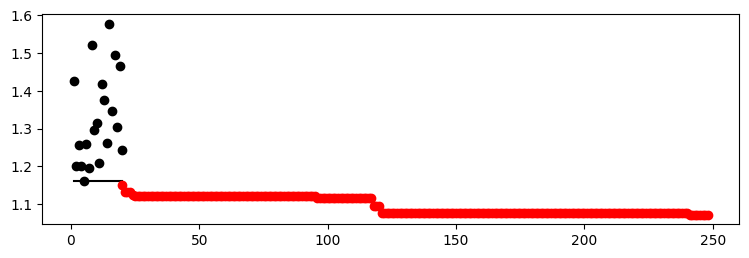

In [22]:
spot_tuner.plot_progress(log_y=False, filename="../Figures.d/" + experiment_name+"_progress.pdf")

* Print the Results

In [23]:
print(gen_design_table(fun_control=fun_control, spot=spot_tuner))

| name       | type   |   default |   lower |   upper |                tuned | transform             |   importance | stars   |
|------------|--------|-----------|---------|---------|----------------------|-----------------------|--------------|---------|
| l1         | int    |       5.0 |     2.0 |     9.0 |                  7.0 | transform_power_2_int |       100.00 | ***     |
| l2         | int    |       5.0 |     2.0 |     9.0 |                  9.0 | transform_power_2_int |         0.00 |         |
| lr         | float  |     0.001 |   1e-05 |    0.01 | 0.005774995349592822 | None                  |         2.90 | *       |
| batch_size | int    |       4.0 |     1.0 |     4.0 |                  4.0 | transform_power_2_int |         1.19 | *       |
| epochs     | int    |       3.0 |     3.0 |     4.0 |                  4.0 | transform_power_2_int |         0.00 |         |
| k_folds    | int    |       2.0 |     0.0 |     0.0 |                  0.0 | None                  |  

## Show variable importance

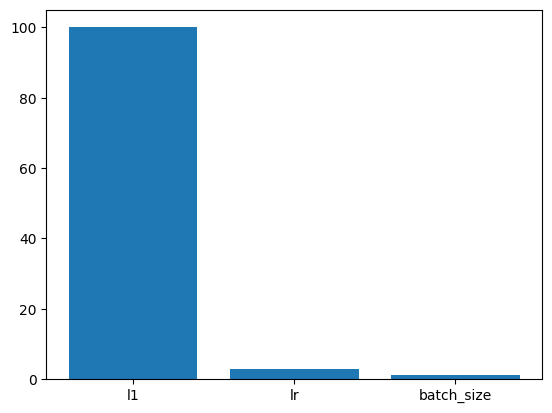

In [24]:
spot_tuner.plot_importance(threshold=0.025, filename="../Figures.d/" + experiment_name+"_importance.pdf")

## Get Default Hyperparameters

In [25]:
values_default = get_default_values(fun_control)
values_default = transform_hyper_parameter_values(fun_control=fun_control, hyper_parameter_values=values_default)
values_default

{'l1': 32,
 'l2': 32,
 'lr': 0.001,
 'batch_size': 16,
 'epochs': 8,
 'k_folds': 2,
 'patience': 5}

In [26]:
model_default = fun_control["core_model"](**values_default)
model_default

Net_CIFAR10(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)

## Get SPOT Results

In [27]:
X = spot_tuner.to_all_dim(spot_tuner.min_X.reshape(1,-1))
print(X)

[[7.00000000e+00 9.00000000e+00 5.77499535e-03 4.00000000e+00
  4.00000000e+00 0.00000000e+00 2.00000000e+00]]


In [28]:
v_dict = assign_values(X, fun_control["var_name"])
return_conf_list_from_var_dict(var_dict=v_dict, fun_control=fun_control)

[{'l1': 128,
  'l2': 512,
  'lr': 0.005774995349592822,
  'batch_size': 16,
  'epochs': 16,
  'k_folds': 0,
  'patience': 2}]

In [29]:
model_spot = get_one_core_model_from_X(X, fun_control)
model_spot

Net_CIFAR10(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
)

## Test Set Accuracy

In [30]:
testset = fun_control["test"]
testset.data.shape

(10000, 32, 32, 3)

In [31]:
evaluate_hold_out(model_default, dataset = testset, shuffle=False, show_batch_interval=1_000)

Epoch: 1
Loss on hold-out set: 2.304289493560791
Accuracy on hold-out set: 0.1035
Epoch: 2
Loss on hold-out set: 2.299320676803589
Accuracy on hold-out set: 0.0985
Epoch: 3
Loss on hold-out set: 2.275272831916809
Accuracy on hold-out set: 0.15725
Epoch: 4
Loss on hold-out set: 2.1671632118225097
Accuracy on hold-out set: 0.18625
Epoch: 5
Loss on hold-out set: 2.0722578482627867
Accuracy on hold-out set: 0.1935
Epoch: 6
Loss on hold-out set: 2.0191542992591858
Accuracy on hold-out set: 0.23825
Epoch: 7
Loss on hold-out set: 1.9774658541679382
Accuracy on hold-out set: 0.2665
Epoch: 8
Loss on hold-out set: 1.9381969480514527
Accuracy on hold-out set: 0.281
Returned to Spot: Validation loss: 1.9381969480514527
----------------------------------------------


(1.9381969480514527, nan)

In [32]:
evaluate_hold_out(model_spot, dataset = testset, shuffle=False, show_batch_interval=1_000)

Epoch: 1
Loss on hold-out set: 2.010735614299774
Accuracy on hold-out set: 0.2415
Epoch: 2
Loss on hold-out set: 1.8911693425178528
Accuracy on hold-out set: 0.3165
Epoch: 3
Loss on hold-out set: 1.7392950277328492
Accuracy on hold-out set: 0.36575
Epoch: 4
Loss on hold-out set: 1.6489489850997925
Accuracy on hold-out set: 0.38875
Epoch: 5
Loss on hold-out set: 1.6056965022087097
Accuracy on hold-out set: 0.40625
Epoch: 6
Loss on hold-out set: 1.576024498462677
Accuracy on hold-out set: 0.4185
Epoch: 7
Loss on hold-out set: 1.5521001420021057
Accuracy on hold-out set: 0.431
Epoch: 8
Loss on hold-out set: 1.5299944880008698
Accuracy on hold-out set: 0.44325
Epoch: 9
Loss on hold-out set: 1.5092597658634186
Accuracy on hold-out set: 0.45075
Epoch: 10
Loss on hold-out set: 1.4892286930084229
Accuracy on hold-out set: 0.45725
Epoch: 11
Loss on hold-out set: 1.4760229487419128
Accuracy on hold-out set: 0.46725
Epoch: 12
Loss on hold-out set: 1.4637594819068909
Accuracy on hold-out set: 0.47

(1.4449129931926727, nan)

## Train on Train Data and Test on Test Data (Hold-Out)

Final Evaluation as in the Pytorch tutorial [Hyperparameter Tuning  with Ray Tune](https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html).

In [33]:
trainset = fun_control["train"]

In [34]:
evaluate_hold_out(net=model_default, dataset=trainset, shuffle=False, test_dataset=testset, show_batch_interval=1_000) 

Epoch: 1
Batch:  1000. Batch Size: 16. Training Loss (running): 1.906
Batch:  2000. Batch Size: 16. Training Loss (running): 0.909
Batch:  3000. Batch Size: 16. Training Loss (running): 0.596
Loss on hold-out set: 1.7406566637039185
Accuracy on hold-out set: 0.3446
Epoch: 2
Batch:  1000. Batch Size: 16. Training Loss (running): 1.748
Batch:  2000. Batch Size: 16. Training Loss (running): 0.854
Batch:  3000. Batch Size: 16. Training Loss (running): 0.567
Loss on hold-out set: 1.663142200088501
Accuracy on hold-out set: 0.3801
Epoch: 3
Batch:  1000. Batch Size: 16. Training Loss (running): 1.670
Batch:  2000. Batch Size: 16. Training Loss (running): 0.817
Batch:  3000. Batch Size: 16. Training Loss (running): 0.545
Loss on hold-out set: 1.6032621837615966
Accuracy on hold-out set: 0.4081
Epoch: 4
Batch:  1000. Batch Size: 16. Training Loss (running): 1.605
Batch:  2000. Batch Size: 16. Training Loss (running): 0.786
Batch:  3000. Batch Size: 16. Training Loss (running): 0.526
Loss on hol

(1.408929964351654, nan)

In [35]:
evaluate_hold_out(net=model_spot, dataset=trainset, shuffle=False, test_dataset=testset, show_batch_interval=1_000)

Epoch: 1
Batch:  1000. Batch Size: 16. Training Loss (running): 1.434
Batch:  2000. Batch Size: 16. Training Loss (running): 0.679
Batch:  3000. Batch Size: 16. Training Loss (running): 0.453
Loss on hold-out set: 1.2676548735618591
Accuracy on hold-out set: 0.5476
Epoch: 2
Batch:  1000. Batch Size: 16. Training Loss (running): 1.284
Batch:  2000. Batch Size: 16. Training Loss (running): 0.621
Batch:  3000. Batch Size: 16. Training Loss (running): 0.419
Loss on hold-out set: 1.217133569908142
Accuracy on hold-out set: 0.5667
Epoch: 3
Batch:  1000. Batch Size: 16. Training Loss (running): 1.196
Batch:  2000. Batch Size: 16. Training Loss (running): 0.581
Batch:  3000. Batch Size: 16. Training Loss (running): 0.394
Loss on hold-out set: 1.1779892863750459
Accuracy on hold-out set: 0.5853
Epoch: 4
Batch:  1000. Batch Size: 16. Training Loss (running): 1.128
Batch:  2000. Batch Size: 16. Training Loss (running): 0.550
Batch:  3000. Batch Size: 16. Training Loss (running): 0.373
Loss on hol

(1.1068494459867477, nan)

## Detailed Hyperparameter Plots

* For productive use, you might want to select:
  * `min_z=min(spot_tuner.y)` and
  * `max_z = max(spot_tuner.y)`
* These settings are not so colorful as visualizations that use `None` for the ranges, but give better insights.

l1:  100.0
lr:  2.897047656303188
batch_size:  1.194924095853355


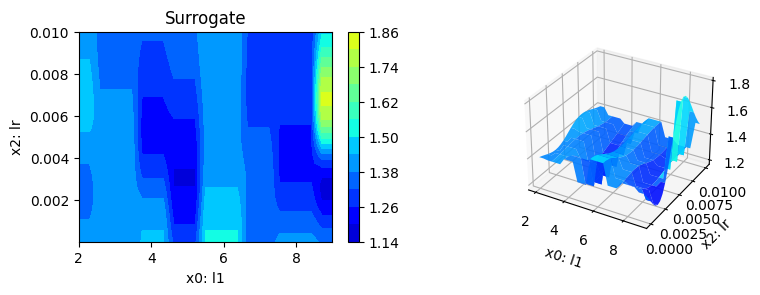

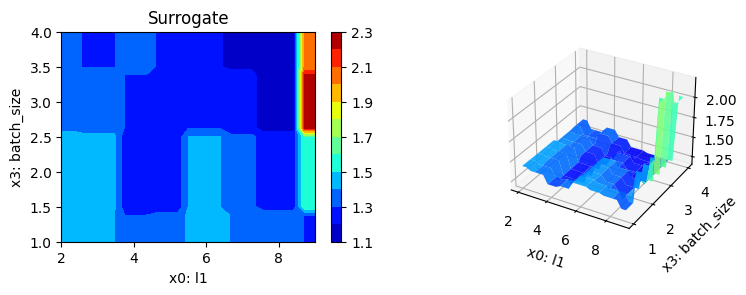

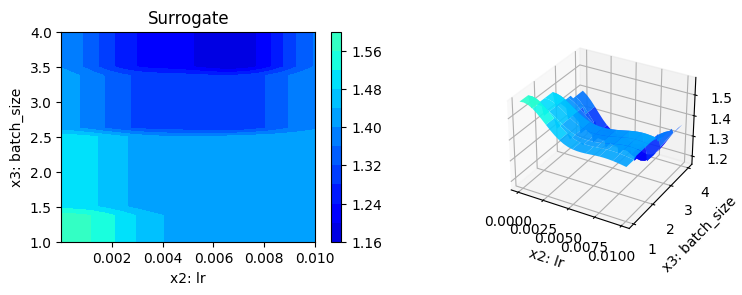

In [36]:
threshold = 0.025
impo = spot_tuner.print_importance(threshold=threshold, print_screen=True)
var_plots = [i for i, x in enumerate(impo) if x[1] > threshold]
min_z = min(spot_tuner.y)
max_z = max(spot_tuner.y)
n = spot_tuner.k
for i in var_plots:
    for j in var_plots:
        if j > i:
            filename = "../Figures.d/" + experiment_name+"_contour_"+str(i)+"_"+str(j)+".pdf"
            spot_tuner.plot_contour(i=i, j=j, min_z=min_z, max_z = max_z, filename=filename)

## Parallel Coordinates Plot

In [37]:
spot_tuner.parallel_plot()

## Plot all Combinations of Hyperparameters

* Warning: this may take a while.

In [38]:
PLOT_ALL = False
if PLOT_ALL:
    n = spot_tuner.k
    for i in range(n-1):
        for j in range(i+1, n):
            spot_tuner.plot_contour(i=i, j=j, min_z=min_z, max_z = max_z)

In [39]:
def train_hold_out(net, trainloader, batch_size, criterion, optimizer, device, show_batch_interval=10_000):
    running_loss = 0.0
    epoch_steps = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        epoch_steps += 1
        if i % show_batch_interval == (show_batch_interval - 1):  # print every show_batch_interval mini-batches
            print(
                "Batch: %5d. Batch Size: %d. Training Loss (running): %.3f"
                % (i + 1, int(batch_size), running_loss / epoch_steps)
            )
            running_loss = 0.0
    return loss.item()